In [1]:
# Standard library imports
import itertools
import re
import string
import warnings

# Third-party library imports for general purposes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
import statsmodels.api as sm
from scipy.sparse import load_npz
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from tpot import TPOTClassifier, TPOTRegressor
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import ParameterGrid
import plotly.express as px


# Text processing and NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Gensim for topic modeling and vector space modeling
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Spacy for advanced NLP
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# Statsmodels for statistical modeling
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Auto ARIMA model
from pmdarima.arima import auto_arima

# Plotting and visualization
from pandas.plotting import parallel_coordinates
from tqdm import tqdm

# Miscellaneous
import pickle
import io

# Suppress warnings
warnings.filterwarnings("ignore")

# NLTK downloads for specific functionalities
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import plotly.figure_factory as ff
from sklearn.cluster import KMeans
from IPython.display import Image
import plotly.io as pio

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

c:\Users\dross\Desktop\Project\venv\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dross\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dross\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dross\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dross\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


GitHub

In [2]:
df = pd.read_csv('./ready_data_score.csv')

df.shape
#Removed target variable due to insufficent count 
df = df[df['subreddit']!='EngineeringCareers']
df['subreddit'] = df['subreddit'].replace({'careeradvice': 'careerguidance'})

df['subreddit'].unique()

array(['careerguidance', 'resumes', 'ITCareerQuestions',
       'FinancialCareers', 'LegalAdviceOffTopic', 'teachers', 'AskHR',
       'sales', 'jobs', 'cscareerquestions'], dtype=object)

In [3]:
# for feature engineering we will need to convert desired features in to numerical representation 
label_encoder = LabelEncoder()

# Fit and transform the 'subreddit' column to obtain encoded target variable
df['subreddit_encoded'] = label_encoder.fit_transform(df['subreddit'])


Convert to weekday and weekend One-hot encode 'day_of_week' and 'month', obtaining a new DataFrame

In [4]:

day_mapping = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7
}

df['day_of_week_encoded'] = df['day_of_week'].map(day_mapping)

month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}

df['month_encoded'] = df['month'].map(month_mapping)


df['is_weekday'] = df['day_of_week'].apply(lambda x: 1 if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 0)
df.head()

,text,title,author,num_comments,post_id,upvote_ratio,score,url,subreddit,link_flair_text,...,created_datetime,day_of_week,hour_of_day,month,year,sentiment_score,subreddit_encoded,day_of_week_encoded,month_encoded,is_weekday
0,Hi context year old guy Amsterdam currently em...,Lazy job or Hard job?,Weak_Assumption_6889,8,1bfpxll,0.33,0,https://www.reddit.com/r/careeradvice/comments...,careerguidance,Unknown,...,2024-03-15 22:07:22,Friday,22,March,2024,0.7579,4,5,3,1
1,Looking new role havenut much traction Recentl...,Roast my Resume Pls,Neither_Trash,1,1bh8md2,0.99,1,https://i.redd.it/n918fjprlyoc1.jpeg,resumes,Review my resume • I'm in North America,...,2024-03-17 21:05:40,Sunday,21,March,2024,0.6369,7,7,3,0
2,I M west bengal bachelor Arts Self taught deve...,Is Jadavpur University good for MCA?,grvx_rdt,0,1bfg926,0.66,1,https://www.reddit.com/r/careeradvice/comments...,careerguidance,Unknown,...,2024-03-15 15:12:00,Friday,15,March,2024,0.8651,4,5,3,1
3,Its created MS word I yoe Java spring bootnn,Review my resume please,GroundbreakingZone94,7,1bh3jpg,0.60,1,https://i.redd.it/tjnti8vplxoc1.jpeg,resumes,Review my resume • I'm in Asia,...,2024-03-17 17:43:39,Sunday,17,March,2024,0.2500,7,7,3,0
4,I live Los Angeles year oldn,Thoughts on My Experience?,AshamedJellyfish9197,1,1bgejk2,0.33,0,https://i.redd.it/ifqv15ry3roc1.jpeg,resumes,Review my resume • I'm in North America,...,2024-03-16 19:53:24,Saturday,19,March,2024,0.0000,7,6,3,0


#to provide more context concatenated text and title then preformed tfidf on the Concatenated title and text

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Removing unicode characters
    text = re.sub(r'\\u[0-9A-Fa-f]+', '', text)
    
    # Removing escape sequences
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'\\', '', text)
    
    # Removing non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing stop words and lemmatizing
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Joining back into a string
    return ' '.join(tokens)

df['processed_text'] = df['text'].apply(preprocess_text)
df['processed_title'] = df['title'].apply(preprocess_text)
df['combined_text'] = df['processed_title'] + ' ' + df['processed_text']

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

# Using matrices and want to combine with encoded_features, you will need to convert them to a dense format
tfidf_dense = tfidf_matrix.toarray()

We combine the dense array with the array_features for one set of features 

In [6]:
#Inorder to cobine all features will have to convert them to an numpy array 
#this dense matrix gives a 7% higher accuracy score but is expensive computional wise 
#solely due to cost ran sparse matrix  but feel free to run either

array_features = df[['num_comments','upvote_ratio','score','hour_of_day','year','day_of_week_encoded','month_encoded','is_weekday','sentiment_score']].values
combined_features = np.hstack((tfidf_dense, array_features))

#target varibale
y = df['subreddit_encoded'].values

In [7]:
#XGB
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)
#Linear_SVC
X_trains, X_tests, y_trains, y_tests = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)

Our hyper tuning techinques for both the linear svc and the XGB boost where a combination of and exhaustive grid search and Baysiean optimization  

In [10]:
#exhaustive grid XGB
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': hp.choice('max_depth', np.arange(1, 15, dtype=int)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'verbosity': hp.choice('verbosity', [0]),
    'n_jobs': -1  # Use all available cores
}

In [57]:
# Baysiean optimization XGB
def objective(params):
    xgb_classifier = XGBClassifier(**params)
    score = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best Hyperparameters for XGBoost:", best)

 45%|████▌     | 45/100 [5:27:06<4:32:00, 296.73s/trial, best loss: -0.6872493685051959] 

In [8]:
XGB = XGBClassifier(learning_rate=0.1132567200427148, max_depth=2, min_child_weight=3.0, n_estimators=100, n_jobs=1, subsample=0.6821295850917053, verbosity=0)
XGB.fit(X_train,y_train)
results = XGB.predict(X_test)


 67% accuracy the dense matrix and pairing of features gave us a 6 percent increase in overall preformance then tthe linearSVC suggested with the Auto ML

In [9]:
#XGBClassifier measurement statistics 
acc = accuracy_score(y_test,results)
print(f'Accuracy: {acc}')

#precision
precision = precision_score(y_test,results,average='weighted')
print(f'Precision: {precision}')
#Recall
recall = recall_score(y_test, results, average='weighted')
print(f'Recall:{recall}')
#f1 Score 
f1 = f1_score(y_test,results,average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.7208848405985686
Precision: 0.7316545164026655
Recall:0.7208848405985686
F1 Score: 0.7213064309031016


The intent of tpot is to assist with model selection tpot gave us a great bench mark model a Linear_SVC that gave good accuracy but after tuning and a pca analysis the final model choosen was an XGboost classifier 

In [ ]:
tpot = TPOTClassifier(generations=10,population_size=100,verbosity=2,random_state=42, config_dict='TPOT sparse')
tpot.fit(X_trains, y_trains)
tpot.export('best_tpot_pipelineV2.py')

In [67]:
exported_pipeline = LinearSVC(C= 0.09695023762026912,dual=False,loss='squared_hinge',penalty='l2',tol=0.000143728759546748,class_weight='balanced') 
#fix random state in exported estimator
if hasattr(exported_pipeline,'random_state'):
    setattr(exported_pipeline,'random_state',42)
    
exported_pipeline.fit(X_trains,y_trains)
result = exported_pipeline.predict(X_tests)

In [30]:
#exhaustive grid LinearSVC
param_grid = {'C':[.01,.1,1,10,100,1000],
              'tol':[.0001,.001,.01,.1],
              'loss':['squared_hinge'],
              'penalty':['l2'],
              'dual':[False]}

grid = list(ParameterGrid(param_grid))

lin_svc =LinearSVC(random_state=42)

best_score = 0
best_params={}

for params in tqdm(grid, desc="GridSearch"):
    
    lin_svc.set_params(**params)
    lin_svc.fit(X_trains,y_trains)
    #Evaluate the model
    current_score = lin_svc.score(X_tests,y_tests)
    
    #update with best score and param
    
    if current_score > best_score:
        best_score = current_score
        best_params = params 
        
print("Best Parameters:",best_params)
print("Best Score:",best_score)


GridSearch: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]

Best Parameters: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.1}
Best Score: 0.6831489915419648


In [20]:
# Baysiean optimization LinearSVC
space = {
    'C': hp.loguniform('C', np.log(0.01), np.log(1000)),
    'tol': hp.loguniform('tol', np.log(0.0001), np.log(0.1)),
    'loss': hp.choice('loss', ['squared_hinge']),
    'penalty': hp.choice('penalty', ['l2']),
    'dual': hp.choice('dual', [False])
}

# Define the objective function
def objective(params):
    lin_svc = LinearSVC(**params, random_state=42)
    score = cross_val_score(lin_svc, X_trains, y_trains, cv=5, scoring='accuracy').mean()
    return {'loss': -score, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best Hyperparameters:", best)

100%|██████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: -0.6280587050359713]
Best Hyperparameters: {'C': 0.09695023762026912, 'dual': 0, 'loss': 0, 'penalty': 0, 'tol': 0.000143728759546748}


In [68]:
acc = accuracy_score(y_tests,result)
print(f'Accuracy: {acc}')

#precision
precision = precision_score(y_tests,result,average='weighted')
print(f'Precision: {precision}')
#Recall
recall = recall_score(y_tests, result, average='weighted')
print(f'Recall:{recall}')
#f1 Score 
f1 = f1_score(y_tests,result,average='weighted')
print(f'F1 Score: {f1}')

Accuracy: 0.6792452830188679
Precision: 0.6852558244033349
Recall:0.6792452830188679
F1 Score: 0.6766348914885751


In [69]:
dummy_clf = DummyClassifier(strategy = 'most_frequent', random_state=42)

dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
print(f'Baseline Accuracy: {accuracy}')

Baseline Accuracy: 0.21795705920624595


XGBoost in comprasion to the linear svc 

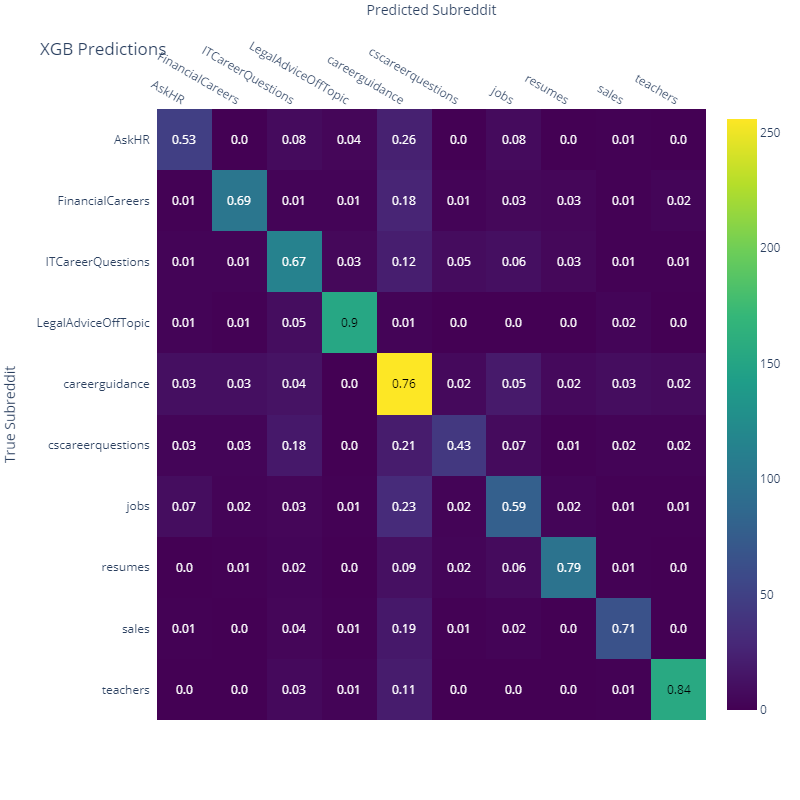

In [70]:
#XGB
predicted_subreddit_names = label_encoder.inverse_transform(results)
true_subreddit_names = label_encoder.inverse_transform(y_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_subreddit_names, predicted_subreddit_names)

# Get unique class names in the right order
sorted_unique_names = np.unique(np.concatenate((true_subreddit_names, predicted_subreddit_names)))

# Create the heatmap
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=sorted_unique_names.tolist(),  
    y=sorted_unique_names.tolist(),  
    colorscale='Viridis',
    annotation_text=np.around(conf_matrix.astype(float) / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2).astype(str),
    hoverinfo="z",
    showscale=True
)

# Update the layout
fig.update_layout(
    title='XGB Predictions',
    xaxis=dict(title='Predicted Subreddit'),
    yaxis=dict(title='True Subreddit', autorange='reversed'),
    width=800,  
    height=800,
)

# Show the figure
fig.show()
# Convert Plotly fig to a static image bytes
img_bytes = pio.to_image(fig, format='png')

# Display the static image
Image(img_bytes)

The linear svc was choose due to it simplicity fronm there we tune with two techiques the costly yet powerful grid search and Bayesian optimization. Bayesian learns statistically which combinations did better

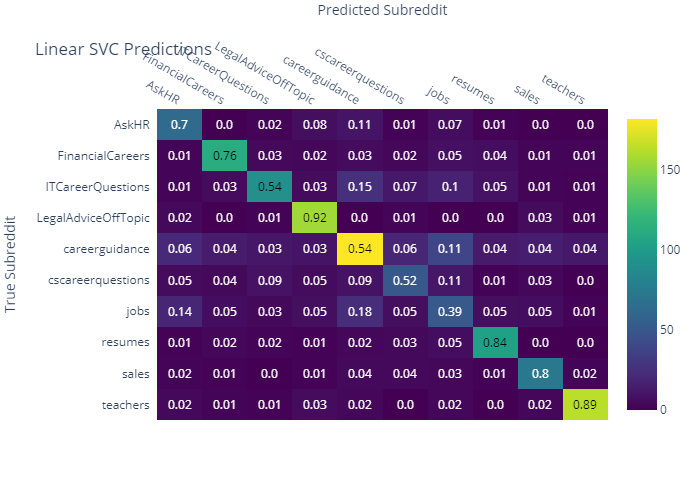

In [14]:
#linear SVC
predicted_subreddit_names = label_encoder.inverse_transform(result)
true_subreddit_names = label_encoder.inverse_transform(y_tests)
conf_matrix = confusion_matrix(y_tests, result)

# Ensure it's in list format
subreddit_names_list = sorted_unique_names.tolist()

# Re-attempt to create the heatmap
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=subreddit_names_list,  # Ensure this is a list
    y=subreddit_names_list,  # Ensure this is a list too
    colorscale='Viridis',
    annotation_text=np.around(conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2),
    hoverinfo="z",
    showscale=True
)

fig.update_layout(
    title='Linear SVC Predictions',
    xaxis=dict(title='Predicted Subreddit'),
    yaxis=dict(title='True Subreddit'),
    yaxis_autorange='reversed'
)
fig.show()
# Convert Plotly fig to a static image bytes
img_bytes = pio.to_image(fig, format='png')

# Display the static image
Image(img_bytes)

Put predictions back into dataframe 

In [33]:
predictions = XGB.predict(combined_features)

# Decode predictions to original labels
decoded_predictions = label_encoder.inverse_transform(predictions)

# Add predictions back to the DataFrame
df['predicted_subreddit'] = decoded_predictions

df.head(10)
# df.to_csv('Final_Predictions.csv', index=False)

,text,title,author,num_comments,post_id,upvote_ratio,score,url,subreddit,link_flair_text,...,sentiment_score,subreddit_encoded,day_of_week_encoded,month_encoded,is_weekday,processed_text,processed_title,combined_text,predicted_subreddit,predicted_subreddit_names
0,Hi context year old guy Amsterdam currently em...,Lazy job or Hard job?,Weak_Assumption_6889,0.000961,1bfpxll,0.294737,0.000000,https://www.reddit.com/r/careeradvice/comments...,careerguidance,Unknown,...,0.878952,4,5,3,1.0,hi context year old guy amsterdam currently em...,lazy job hard job,lazy job hard job hi context year old guy amst...,jobs,jobs
1,Looking new role havenut much traction Recentl...,Roast my Resume Pls,Neither_Trash,0.000120,1bh8md2,0.989474,0.000023,https://i.redd.it/n918fjprlyoc1.jpeg,resumes,Review my resume • I'm in North America,...,0.818427,7,7,3,0.0,looking new role havenut much traction recentl...,roast resume pls,roast resume pls looking new role havenut much...,resumes,resumes
2,I M west bengal bachelor Arts Self taught deve...,Is Jadavpur University good for MCA?,grvx_rdt,0.000000,1bfg926,0.642105,0.000023,https://www.reddit.com/r/careeradvice/comments...,careerguidance,Unknown,...,0.932573,4,5,3,1.0,west bengal bachelor art self taught developer...,jadavpur university good mca,jadavpur university good mca west bengal bache...,careerguidance,careerguidance
3,Its created MS word I yoe Java spring bootnn,Review my resume please,GroundbreakingZone94,0.000841,1bh3jpg,0.578947,0.000023,https://i.redd.it/tjnti8vplxoc1.jpeg,resumes,Review my resume • I'm in Asia,...,0.624900,7,7,3,0.0,created m word yoe java spring bootnn,review resume please,review resume please created m word yoe java s...,resumes,resumes
4,I live Los Angeles year oldn,Thoughts on My Experience?,AshamedJellyfish9197,0.000120,1bgejk2,0.294737,0.000000,https://i.redd.it/ifqv15ry3roc1.jpeg,resumes,Review my resume • I'm in North America,...,0.499850,7,6,3,0.0,live los angeles year oldn,thought experience,thought experience live los angeles year oldn,ITCareerQuestions,ITCareerQuestions
5,I know resume place I would absolutely love ad...,Resume advice would be much appreciated!,Deep_Geologist7167,0.000961,1bdsw03,1.000000,0.000116,https://i.redd.it/4z0j0pcm34oc1.jpeg,resumes,Review my resume • I'm in North America,...,0.935924,7,3,3,1.0,know resume place would absolutely love advice...,resume advice would much appreciated,resume advice would much appreciated know resu...,resumes,resumes
6,I going day ticker soon criticize everything s...,"1000+ Applications, 1 interview. International...",Old-Purple-9140,0.000120,1bfjvot,1.000000,0.000023,https://i.redd.it/ing1c52ocjoc1.jpeg,resumes,Review my resume • I'm in North America,...,0.486945,7,5,3,1.0,going day ticker soon criticize everything see...,application interview international student ma...,application interview international student ma...,teachers,teachers
7,Hello everyonennIve applying remote customer s...,Remote Customer Service - Which one of these i...,the_sweetest_peach,0.000120,1bcdone,1.000000,0.000023,https://www.reddit.com/r/resumes/comments/1bcd...,resumes,Review my resume • I'm in North America,...,0.856192,7,1,3,1.0,hello everyonennive applying remote customer s...,remote customer service one best need lot help,remote customer service one best need lot help...,resumes,resumes
8,Advice resume,CS resume for internships,Unlikely-Bowler-5498,0.000360,1bb3lbe,0.473684,0.000000,https://i.redd.it/48fn1c11bgnc1.jpeg,resumes,Review my resume • I'm in North America,...,0.499850,7,7,3,0.0,advice resume,c resume internship,c resume internship advice resume,resumes,resumes
9,Hey folksr nr nIve hit snag job search could r...,Navigating Multiple Job Applications with a Si...,DullMango,0.000000,1bc4ppa,1.000000,0.000023,https://www.reddit.com/r/careeradvice/comments...,careerguidance,Unknown,...,0.845388,4,1,3,1.0,hey folksr nr nive hit snag job search could r...,navigating multiple job application single lin...,navigating multiple 

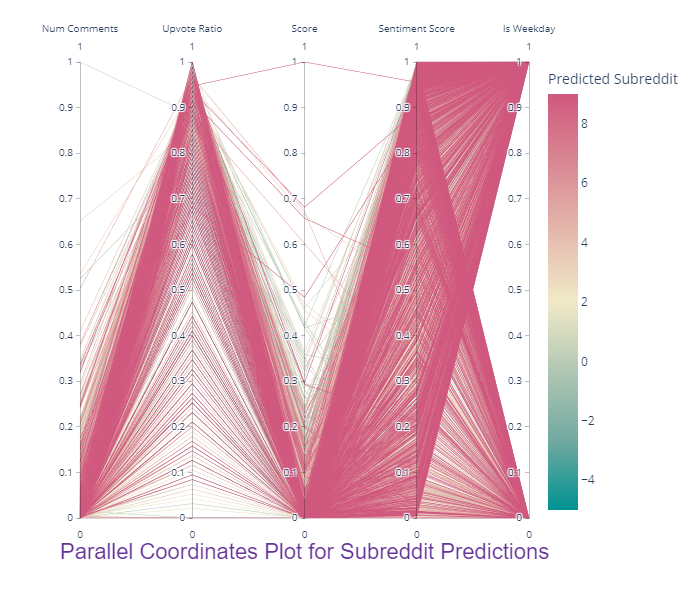

In [71]:
if df['predicted_subreddit'].dtype == 'object':
    df['predicted_subreddit'] = df['predicted_subreddit'].astype('category').cat.codes



features_to_normalize = ['num_comments', 'upvote_ratio', 'score', 'sentiment_score', 'is_weekday']
for feature in features_to_normalize:
    df[feature] = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())


features_to_plot = ['num_comments', 'upvote_ratio', 'score', 'sentiment_score', 'is_weekday', 'predicted_subreddit']

# Create the parallel coordinates plot
fig = px.parallel_coordinates(
    df[features_to_plot], 
    color='predicted_subreddit',
    labels={col: col.replace('_', ' ').title() for col in features_to_plot},
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=2
)

# Update layout for clarity
fig.update_layout(
    annotations=[
        dict(
            text='Parallel Coordinates Plot for Subreddit Predictions',  
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0.5,
            y=-0.1, 
            xanchor='center',
            yanchor='auto',
            font=dict(
                family="Arial, sans-serif",
            size=22,
            color="RebeccaPurple" 
            )
        )
    ],
    height=600,
    xaxis=dict(
        tickvals=list(range(len(features_to_plot))),  
        ticktext=[col.replace('_', ' ').title() for col in features_to_plot]  
    )
)

# Show the figure
fig.show()

# Convert Plotly fig to a static image bytes
img_bytes = pio.to_image(fig, format='png')

# Display the static image
Image(img_bytes)